In [7]:
import os
from functools import cache
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from audmetric import accuracy

In [8]:
font_size = 13
figsize = (6, 3)
rcParams = {
    "font.size": font_size,
    "font.family": "serif",
    "font.serif": "Times New Roman",
}
sns.set_theme(context="notebook", style="whitegrid", palette="colorblind", rc=rcParams)

In [9]:
def read_pacing_metrics(path: str, subdir: str = "summary") -> pd.DataFrame:
    metrics_df = pd.read_csv(f"{path}/{subdir}/metrics.csv")
    config_df = pd.read_csv(f"{path}/{subdir}/config.csv")
    df = pd.merge(metrics_df, config_df, on="run_name")
    return df


def select_baseline_runs(df: pd.DataFrame, dataset: str) -> Dict[str, str]:
    df = df[~df["curriculum"].notnull()]
    df = df[df["model"] == "EfficientNet-B0"]
    optim = "Adam" if dataset == "cifar" else "SAM-SGD-M9"
    lr = 0.001 if dataset == "cifar" else 0.01
    df = df[(df["optimizer"] == optim) & (df["learning_rate"] == lr)]
    df = df.sort_values("test_accuracy", ascending=False)
    runs = {f"B{i+1}": run for i, run in enumerate(df["run_name"].to_list())}
    return runs


def select_pacing_runs(df: pd.DataFrame) -> Dict[str, str]:
    def _assign_ordering_type(row) -> str:
        if row["curriculum"] == "AntiCurriculum":
            return "ACL"
        if row["curriculum.scoring.type"] == "Random":
            return "RCL"
        return "CL"

    df = df[df["curriculum"].notnull()]
    df = df[~df["curriculum.scoring"].str.contains("\+")]
    df = df[~df["run_name"].str.contains("-S\d")]
    df["curriculum.type"] = df.apply(_assign_ordering_type, axis=1)
    df = (
        df.sort_values("test_accuracy", ascending=False)
        .groupby("curriculum.type")
        .head(1)
    )
    runs = df[["curriculum.type", "run_name"]].to_dict(orient="records")
    return {run["curriculum.type"]: run["run_name"] for run in runs}


def select_runs(dataset: str) -> Tuple[Dict[str, str], Dict[str, str]]:
    df = read_pacing_metrics(f"results/{dataset}")
    baseline_runs = select_baseline_runs(df, dataset)
    pacing_runs = select_pacing_runs(df)
    return baseline_runs, pacing_runs

In [10]:
@cache
def load_npy(
    run_name: str,
    dataset: str,
    filename: str = "test_outputs",
) -> np.ndarray:
    return np.load(f"results/{dataset}/training/{run_name}/_test/{filename}.npy")


def late_fusion_accuracy(*args: List[str], ds: str) -> float:
    pred = []
    for arg in args:
        x = load_npy(arg, ds)
        pred.append(torch.nn.functional.softmax(torch.from_numpy(x), dim=1))
    pred = sum(pred).argmax(dim=1).numpy()
    y = load_npy(args[0], ds, "test_targets")
    return accuracy(y, pred)


def create_late_fusion(b: Dict[str, str], p: Dict[str, str], ds: str) -> pd.DataFrame:
    records = [
        ("B2", 2, late_fusion_accuracy(b["B1"], b["B2"], ds=ds)),
        ("B3", 3, late_fusion_accuracy(b["B1"], b["B2"], b["B3"], ds=ds)),
        (
            "B4",
            4,
            late_fusion_accuracy(b["B1"], b["B2"], b["B3"], b["B4"], ds=ds),
        ),
        (
            "B5",
            5,
            late_fusion_accuracy(b["B1"], b["B2"], b["B3"], b["B4"], b["B5"], ds=ds),
        ),
        ("B15", 15, late_fusion_accuracy(*b.values(), ds=ds)),
        ("CL, RCL", 2, late_fusion_accuracy(p["CL"], p["RCL"], ds=ds)),
        ("CL, ACL", 2, late_fusion_accuracy(p["CL"], p["ACL"], ds=ds)),
        ("CL, B1", 2, late_fusion_accuracy(b["B1"], p["CL"], ds=ds)),
        ("RCL, ACL", 2, late_fusion_accuracy(p["RCL"], p["ACL"], ds=ds)),
        ("RCL, B1", 2, late_fusion_accuracy(b["B1"], p["RCL"], ds=ds)),
        ("ACL, B1", 2, late_fusion_accuracy(b["B1"], p["ACL"], ds=ds)),
        (
            "CL, RCL, ACL",
            3,
            late_fusion_accuracy(p["CL"], p["RCL"], p["ACL"], ds=ds),
        ),
        (
            "CL, ACL, B1",
            3,
            late_fusion_accuracy(p["CL"], p["ACL"], b["B1"], ds=ds),
        ),
        (
            "CL, RCL, B1",
            3,
            late_fusion_accuracy(p["CL"], p["RCL"], b["B1"], ds=ds),
        ),
        (
            "RCL, ACL, B1",
            3,
            late_fusion_accuracy(p["RCL"], p["ACL"], b["B1"], ds=ds),
        ),
        (
            "CL, RCL, ACL, B1",
            4,
            late_fusion_accuracy(p["CL"], p["RCL"], p["ACL"], b["B1"], ds=ds),
        ),
    ]
    return pd.DataFrame(records, columns=["Fusion", "Size", "Accuracy"]).sort_values(
        "Accuracy", ascending=False
    )

In [11]:
cifar_df = create_late_fusion(*select_runs("cifar"), "cifar").reset_index(drop=True)
dcase_df = create_late_fusion(*select_runs("dcase"), "dcase")
dcase_df = dcase_df.set_index("Fusion").reindex(cifar_df["Fusion"]).reset_index()
os.makedirs("results/tables", exist_ok=True)
df = pd.concat([cifar_df, dcase_df], axis=1, keys=["CIFAR", "DCASE2020"])
df.to_csv("results/tables/4_c_4_fusion_performance.csv", index=False)

In [12]:
df.round(3)

CIFAR                       DCASE2020              
              Fusion Size Accuracy            Fusion Size Accuracy
0                B15   15    0.894               B15   15    0.630
1                 B5    5    0.886                B5    5    0.632
2   CL, RCL, ACL, B1    4    0.884  CL, RCL, ACL, B1    4    0.636
3                 B4    4    0.882                B4    4    0.632
4        CL, ACL, B1    3    0.877       CL, ACL, B1    3    0.624
5        CL, RCL, B1    3    0.876       CL, RCL, B1    3    0.629
6       CL, RCL, ACL    3    0.876      CL, RCL, ACL    3    0.627
7       RCL, ACL, B1    3    0.875      RCL, ACL, B1    3    0.615
8                 B3    3    0.875                B3    3    0.628
9            CL, ACL    2    0.868           CL, ACL    2    0.621
10            CL, B1    2    0.867            CL, B1    2    0.620
11           CL, RCL    2    0.867           CL, RCL    2    0.617
12           RCL, B1    2    0.865           RCL, B1    2    0.600
13                B2    2    0.862                B2    2    0.603
14           ACL, B1    2    0.861           ACL, B1    2    0.607
15          RCL, ACL    2    0.856          RCL, ACL    2    0.597

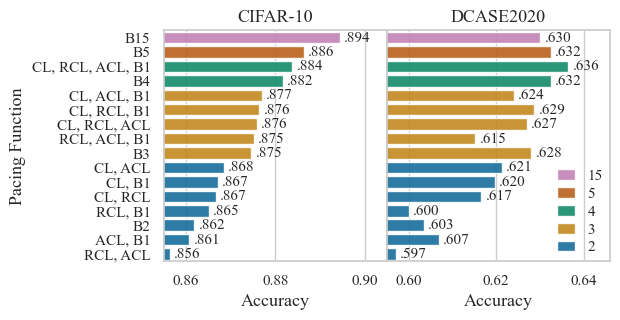

In [13]:
fig = plt.figure(figsize=figsize)
for i, df in enumerate([cifar_df, dcase_df]):
    ax = fig.add_subplot(1, 2, i + 1)
    sns.barplot(
        data=df,
        y="Fusion",
        x="Accuracy",
        hue="Size",
        ax=ax,
        alpha=0.9,
        palette="colorblind",
    )
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt=lambda x: f"{x:.3f}".lstrip("0"),
            label_type="edge",
            padding=3,
            fontsize=font_size - 2,
        )
    ax.set_title("CIFAR-10" if i == 0 else "DCASE2020", fontsize=font_size)
    ax.set_xlabel("Accuracy", fontsize=font_size)
    ax.set_ylabel("Pacing Function", fontsize=font_size)
    ax.get_legend().remove()
    # plt.xlim(left=0.85, right=0.8975)
    plt.xlim(left=0.855, right=0.905)
    if i == 1:
        ax.set_ylabel("")
        plt.setp(ax.get_yticklabels(), visible=False)
        # plt.xlim(left=0.5875, right=0.639)
        plt.xlim(left=0.595, right=0.646)
        plt.subplots_adjust(wspace=0)
        plt.legend(
            handles=ax.get_legend_handles_labels()[0][::-1],
            labels=ax.get_legend_handles_labels()[1][::-1],
            title=None,
            frameon=False,
            loc="lower right",
            bbox_to_anchor=(1.03, -0.03),
            handlelength=1.2,
            fontsize=font_size - 2,
            labelspacing=0.25,
        )

plt.tight_layout(pad=0)
os.makedirs("results/figures", exist_ok=True)
plt.savefig("results/figures/4_c_4_fusion_performance.pdf", dpi=300)